# Model 1: TimeSeries

## Input :
- receivals.csv
## Serie for each raw material
- net weight delivered each day from 2014 to 2024
- fill with 0 when no deliverie


# observation of a big change in 2012 -> start data after 2012 

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [126]:
start_date = "2004-01-01"

In [127]:
receivals = pd.read_csv('./data/kernel/receivals.csv')


receivals = receivals.dropna(subset=["net_weight"])
print(len(receivals))
receivals = receivals[receivals["net_weight"] > 0]
print(len(receivals))
#df_nan = receivals[receivals["net_weight"].isna()]
receivals['date_arrival'] = (
    pd.to_datetime(receivals['date_arrival'], utc=True)
      .dt.tz_localize(None)
      .dt.normalize()
)
# ///!!!!\\\\\\\ enlevement des données <2012
receivals = receivals[receivals["date_arrival"] >= pd.Timestamp(start_date)].reset_index(drop=True)


print(receivals['date_arrival'][0])

daily = (
    receivals.groupby(["rm_id","date_arrival"], as_index=False)
             .agg(
                 net_weight_sum=("net_weight", "sum")
             ).rename(columns={"date_arrival": "date","net_weight_sum":"net_weight"})
             .sort_values(["rm_id","date"])
)
print(len(daily))
print(daily.head(10))

122522
122385
2004-06-15 00:00:00
41906
   rm_id       date  net_weight
0  342.0 2004-06-23     24940.0
1  343.0 2005-03-29     21760.0
2  345.0 2004-09-01     22780.0
3  346.0 2004-06-24       820.0
4  346.0 2004-06-30     21260.0
5  346.0 2004-07-28      2880.0
6  347.0 2004-06-17     29805.0
7  347.0 2004-06-21     14920.0
8  347.0 2004-07-28     11200.0
9  347.0 2004-09-03     20220.0


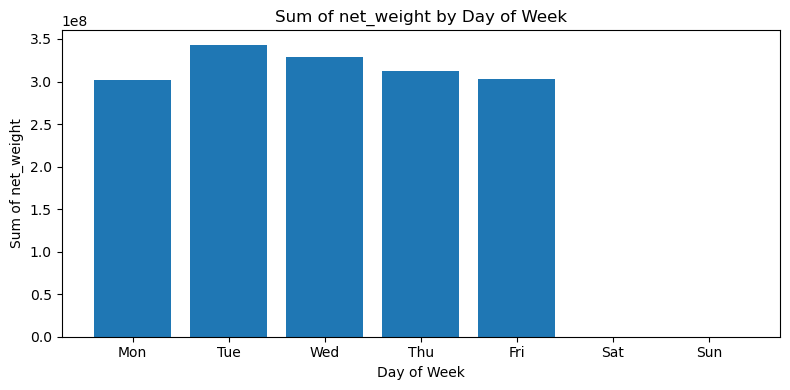

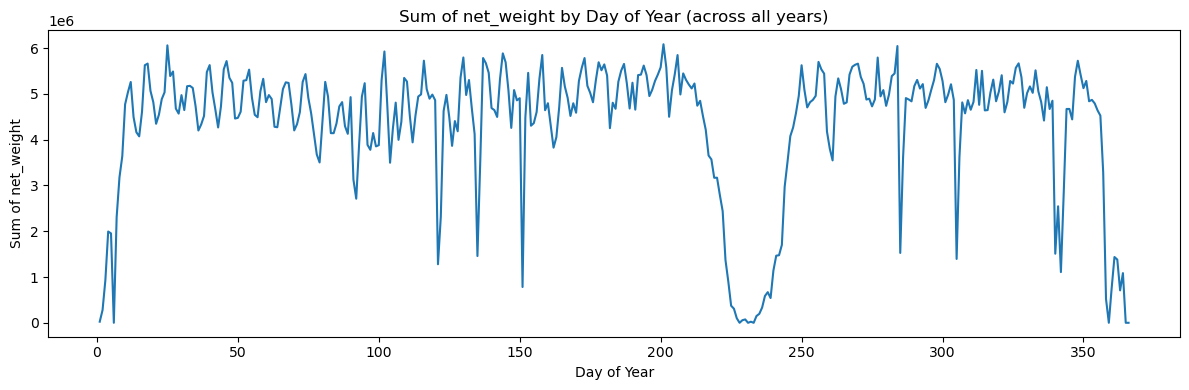

In [128]:
dow_order = list(range(7))
dow_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

sum_by_dow = (
    daily.groupby(daily["date"].dt.dayofweek)["net_weight"]
      .sum()
      .reindex(dow_order, fill_value=0)
)

plt.figure(figsize=(8, 4))
plt.bar(dow_labels, sum_by_dow.values)
plt.title("Sum of net_weight by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Sum of net_weight")
plt.tight_layout()
plt.show()

sum_by_doy = (
    daily.groupby(daily["date"].dt.dayofyear)["net_weight"]
      .sum()
      .reindex(range(1, 367), fill_value=0)  # include leap day position if needed
)

plt.figure(figsize=(12, 4))
plt.plot(sum_by_doy.index, sum_by_doy.values)
plt.title("Sum of net_weight by Day of Year (across all years)")
plt.xlabel("Day of Year")
plt.ylabel("Sum of net_weight")
plt.tight_layout()
plt.show()

# remove rm_id that wasn't delivered for 5 years and less that 3 in total

In [129]:
stats = (
    daily.groupby("rm_id")
            .agg(
                last_delivery=("date", "max"),
                total_deliveries=("date", "count")  # number of delivery-days
            )
)
cutoff = pd.Timestamp("2024-12-31") - pd.DateOffset(years=5)

rare_rm_id = stats.index[(stats["last_delivery"] <= cutoff) & (stats["total_deliveries"] <= 3)]

print(rare_rm_id)
print(len(rare_rm_id))

# I remove rare_rm_id 
print(len(daily["rm_id"].unique()))
daily = daily[~daily["rm_id"].isin(rare_rm_id)].reset_index(drop=True)

print(len(daily["rm_id"].unique()))

Index([ 342.0,  343.0,  345.0,  346.0,  348.0,  353.0,  355.0,  358.0,  360.0,
        362.0,  374.0,  380.0,  387.0,  390.0, 1844.0, 1845.0, 1858.0, 1872.0,
       1882.0, 2001.0, 2061.0, 2128.0, 2141.0, 2158.0, 2323.0, 2341.0, 2343.0,
       2344.0, 2345.0, 2347.0, 2362.0, 2363.0, 2421.0, 2841.0, 2861.0],
      dtype='float64', name='rm_id')
35
203
168


In [130]:

# 3) Build the full MultiIndex (all rm_id x all days in the range)
full_start = pd.Timestamp(start_date) # change it also 
full_end   = pd.Timestamp("2024-12-31")
print(full_start)
rm_ids = pd.Index(daily["rm_id"].unique(), name="rm_id")
calendar = pd.date_range(full_start, full_end, freq="D", name="date")
full_idx = pd.MultiIndex.from_product([rm_ids, calendar], names=["rm_id","date"])

# 4) Reindex to the full grid and fill missing with 0
daily = (
    daily.set_index(["rm_id","date"])["net_weight"]
         .reindex(full_idx, fill_value=0)
         .reset_index()
)
daily.head(10)

2004-01-01 00:00:00


,rm_id,date,net_weight
0,347.0,2004-01-01,0.0
1,347.0,2004-01-02,0.0
2,347.0,2004-01-03,0.0
3,347.0,2004-01-04,0.0
4,347.0,2004-01-05,0.0
5,347.0,2004-01-06,0.0
6,347.0,2004-01-07,0.0
7,347.0,2004-01-08,0.0
8,347.0,2004-01-09,0.0
9,347.0,2004-01-10,0.0


In [ ]:
forecast_start = pd.Timestamp("2025-01-01")
forecast_end   = pd.Timestamp("2025-05-31")

predictions = []

for rm in daily["rm_id"].unique():
    # 1) build a daily series with explicit daily freq
    series = (
        daily.loc[daily["rm_id"] == rm, ["date", "net_weight"]]
                .set_index("date")["net_weight"]
                .asfreq("D")
    )

    # (optional) skip super-short histories
    if 0==1 and series.shape[0] < 30:
        # naive baseline: all zeros (or series.tail(28).mean())
        fc = pd.Series(0.0, index=pd.date_range(forecast_start, forecast_end, freq="D"))
    else:
        # 2) fit Holt–Winters (additive handles zeros safely)
        model = ExponentialSmoothing(
            series,
            trend="add",
            seasonal="add",
            seasonal_periods=7,
            initialization_method="estimated",
        ).fit(optimized=True)

        # 3) predict using calendar dates (works because the index has freq='D')
        fc = model.predict(start=forecast_start, end=forecast_end)

    # 4) shape for concatenation
    pred = (
        fc.rename("net_weight") 
          .reset_index()
          .rename(columns={"index": "date"})
    )
    #pred["net_weight"] = pred["net_weight"].clip(lower=0) # have deliveries >=0
    pred["rm_id"] = rm
    
    predictions.append(pred)

# 5) all rm_id forecasts
df_forecast = pd.concat(predictions, ignore_index=True)



Index([2130.0, 1903.0, 2160.0, 2140.0, 1909.0], dtype='float64', name='rm_id')


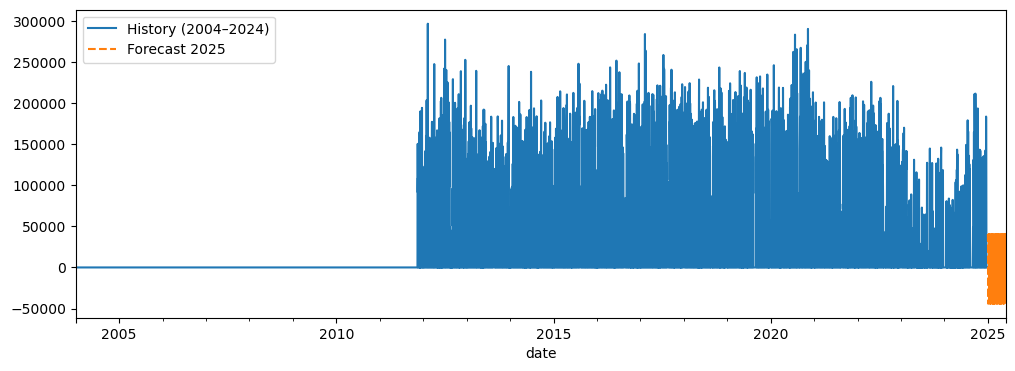

In [132]:
top_rm_ids = daily.groupby('rm_id')['net_weight'].sum().nlargest(5).index
print(top_rm_ids)
rm = 2130.0
history = daily[daily["rm_id"] == rm].set_index("date")["net_weight"]
future = df_forecast[df_forecast["rm_id"] == rm].set_index("date")["net_weight"]

plt.figure(figsize=(12,4))
history.plot(label="History (2004–2024)")
future.plot(label="Forecast 2025", style="--")
plt.legend()
plt.show()
#don't work very well.

training on 1 rm

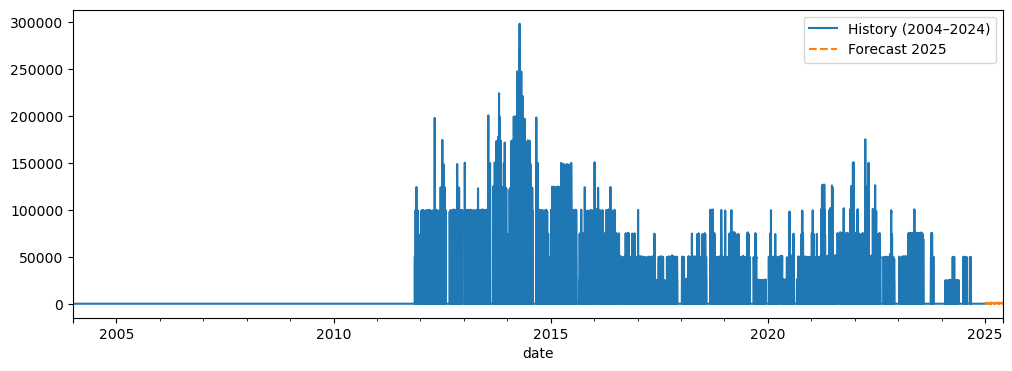

In [133]:
rm = 2140.0

# 1) build a daily series with explicit daily freq
series = (
    daily.loc[daily["rm_id"] == rm, ["date", "net_weight"]]
            .set_index("date")["net_weight"]
            .asfreq("D")
)

# (optional) skip super-short histories
if 0==1 and series.shape[0] < 30:
    # naive baseline: all zeros (or series.tail(28).mean())
    fc = pd.Series(0.0, index=pd.date_range(forecast_start, forecast_end, freq="D"))
else:
    # 2) fit Holt–Winters (additive handles zeros safely)
    model = ExponentialSmoothing(
        series,
        trend="add",
        seasonal="add",
        seasonal_periods=7,
        initialization_method="estimated",
    ).fit(optimized=True)

    # 3) predict using calendar dates (works because the index has freq='D')
    fc = model.predict(start=forecast_start, end=forecast_end)

# 4) shape for concatenation
pred = (
    fc.rename("net_weight")
        .reset_index()
        .rename(columns={"index": "date"})
)
pred["net_weight"] = pred["net_weight"].clip(lower=0)

history = daily[daily["rm_id"] == rm].set_index("date")["net_weight"]
future = pred.set_index("date")["net_weight"]

plt.figure(figsize=(12,4))
history.plot(label="History (2004–2024)")
future.plot(label="Forecast 2025", style="--")
plt.legend()
plt.show()


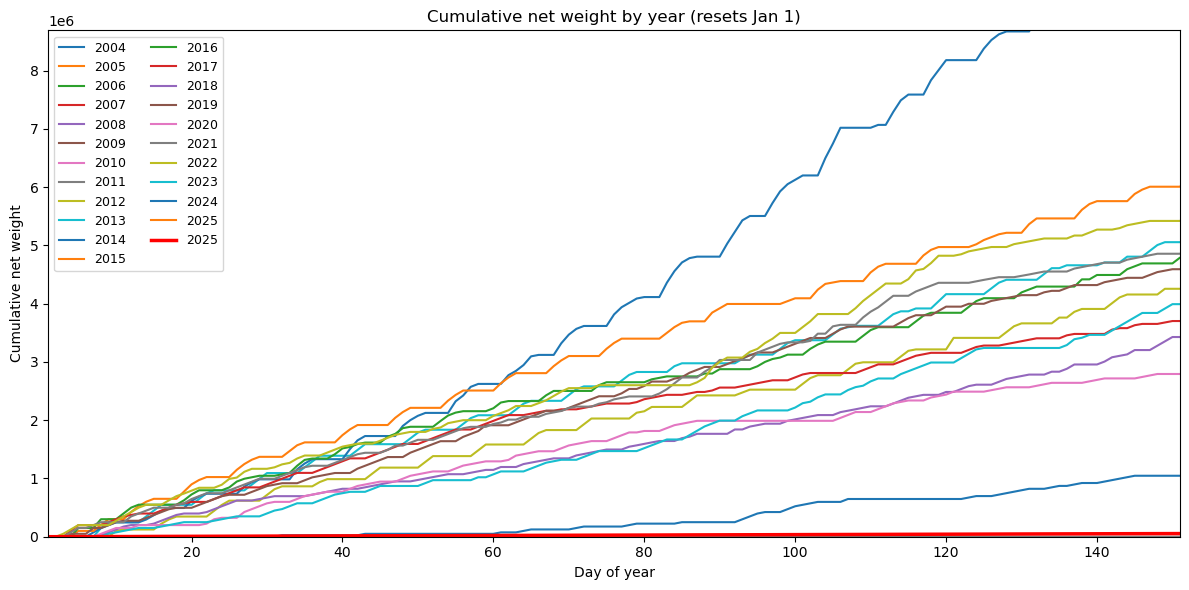

In [134]:
history = daily[daily["rm_id"] == rm]

combined = (
    pd.concat([history, pred], ignore_index=True)
      .sort_values("date")
      .reset_index(drop=True)
)


# If df_daily has per-rm rows, collapse to "all deliveries per day"
# (skip this block if you already have one row per date)
total_daily = (
    combined.groupby("date", as_index=False)["net_weight"].sum()
)
# ensure datetime
total_daily["date"] = pd.to_datetime(total_daily["date"])

# Add calendar helpers
total_daily["year"] = total_daily["date"].dt.year
total_daily["doy"]  = total_daily["date"].dt.dayofyear

# Cumulative sum that resets each year
total_daily["cum_net"] = total_daily.groupby("year")["net_weight"].cumsum()

# (Optional) keep only recent years to avoid a spaghetti plot
# total_daily = total_daily[total_daily["year"] >= 2018]

# Plot: one line per year, x = day-of-year, y = cumulated net weight
plt.figure(figsize=(12,6))
for year, g in total_daily.groupby("year"):
    plt.plot(g["doy"], g["cum_net"], label=str(year))


g2025 = total_daily[total_daily["year"] == 2025]
plt.plot(g2025["doy"], g2025["cum_net"], color="red",linewidth=2.5, label="2025")

ymin = 0
ymax = (
    total_daily[total_daily["date"] <= pd.Timestamp("2025-05-31")]
    .groupby("year")["cum_net"].max()
    .max()
)
plt.ylim(ymin, ymax/2)

plt.xlim(1, pd.Timestamp("2025-05-31").dayofyear)
plt.title("Cumulative net weight by year (resets Jan 1)")
plt.xlabel("Day of year")
plt.ylabel("Cumulative net weight")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


Creation du fichier de soumission

In [ ]:
#Fichier des predictions
df_cum  = (
    df_forecast.sort_values(["rm_id", "date"])
        .groupby("rm_id", as_index=False)
        .apply(lambda g: g.assign(cum=g["net_weight"].cumsum()))
        .reset_index(drop=True)
        [["rm_id", "date", "cum"]]
)
df_cum["cum"] = df_cum["cum"].clip(lower=0)
# 2) ajout des valeurs nulles 
dates = pd.date_range("2025-01-01", "2025-05-03", freq="D")

df_new  = (
    pd.MultiIndex.from_product([rare_rm_id, dates], names=["rm_id", "date"])
      .to_frame(index=False)
      .assign(cum=0)
)
df_final = pd.concat([df_cum, df_new], ignore_index=True)

df_final["rm_id"] = pd.to_numeric(df_cum["rm_id"], errors="coerce").astype("Int64")

# 3) Load the ID mapping
ids = pd.read_csv("./data/prediction_mapping.csv")  # or your actual path
ids["forecast_start_date"] = pd.to_datetime(ids["forecast_start_date"])
ids["forecast_end_date"]   = pd.to_datetime(ids["forecast_end_date"])
ids["rm_id"]    = pd.to_numeric(ids["rm_id"], errors="coerce").astype("Int64")
ids = ids.rename(columns={
    "forecast_end_date": "date"
})

# 4) For each ID, get cum at end_date (<= end_date)

out = (
    ids.merge(df_final, on=["rm_id", "date"], how="left")
       .assign(cum=lambda d: d["cum"].fillna(0))   # cum=0 quand absent
       .sort_values(["rm_id", "date"])
       .reset_index(drop=True)
)


# 5) Cum at day before start_date
submission = (
    out[["ID", "cum"]]
      .rename(columns={"cum": "predicted_weight"})   # if your file needs "predicted_weight"
      .fillna({"predicted_weight": 0})
      .sort_values("ID")
)

submission.to_csv("./submissions/submission.csv", index=False)
print(submission.head())

      ID  predicted_weight
2100   1               0.0
2101   2               0.0
2102   3               0.0
2103   4               0.0
2104   5               0.0


C:\Users\julie\AppData\Local\Temp\ipykernel_23092\3106444687.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(cum=g["net_weight"].cumsum()))
